In [1]:
# -*- coding: utf-8 -*-

import sys,os
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy import linalg
from numpy import dot
import geomloss as gs
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as D
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.autograd import grad
import torch.utils.data
import torch.backends.cudnn as cudnn
from torch.nn.modules import Linear
from torch.autograd.functional import jacobian,hessian,vjp,vhp,hvp

import random
import math

In [2]:
data = pd.read_table("CellCycleData.txt", header="infer",sep=' ')
mat = data.values

cell_G1 = mat[0:96,:]
cell_G2 = mat[96:192,:]
cell_S = mat[192:,:]

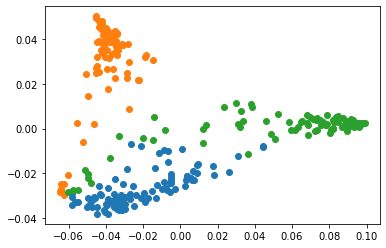

In [3]:
plt.scatter(cell_G1[:,0],cell_G1[:,1])
plt.scatter(cell_S[:,0],cell_S[:,1])
plt.scatter(cell_G2[:,0],cell_G2[:,1])

In [4]:
train0 = torch.tensor(cell_G1,dtype=torch.float32,requires_grad = True,device="cuda")
train2 = torch.tensor(cell_S,dtype=torch.float32,requires_grad = True,device="cuda")
train4 = torch.tensor(cell_G2,dtype=torch.float32,requires_grad = True,device="cuda")
train7 = torch.tensor(cell_G1,dtype=torch.float32,requires_grad = True,device="cuda")

In [5]:
# multi-layer perceptron
class MLP(nn.Module):

    def __init__(self, dim_in, dim_out, dim_hidden=64, num_hidden=0, activation=nn.LeakyReLU()):
        super(MLP, self).__init__()

        if num_hidden == 0:
            self.linears = nn.ModuleList([nn.Linear(dim_in, dim_out)])
        elif num_hidden >= 1:
            self.linears = nn.ModuleList() 
            self.linears.append(nn.Linear(dim_in, dim_hidden))
            self.linears.extend([nn.Linear(dim_hidden, dim_hidden) for _ in range(num_hidden-1)])
            self.linears.append(nn.Linear(dim_hidden, dim_out))
        else:
            raise Exception('number of hidden layers must be positive')

        for m in self.linears:
            nn.init.xavier_normal_(m.weight)
            nn.init.uniform_(m.bias,a=-0.1,b=0.1)
 
        self.activation = activation 

    def forward(self, x):
        for m in self.linears[:-1]:
            x = self.activation(m(x))

        return self.linears[-1](x)


def compute_gradient_penalty(D, real_sample, fake_sample,k,p):
    real_samples = real_sample.requires_grad_(True)
    fake_samples = fake_sample.requires_grad_(True)

    real_validity = D(real_samples)
    fake_validity = D(fake_samples)

    real_grad_out = torch.ones((real_samples.shape[0],1),dtype=torch.float32,requires_grad=False,device="cuda")
    real_grad = grad(
        real_validity, real_samples, real_grad_out, create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    real_grad_norm = real_grad.view(real_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

    fake_grad_out = torch.ones((fake_samples.shape[0],1),dtype=torch.float32,requires_grad=False,device="cuda")
    fake_grad = grad(
        fake_validity, fake_samples, fake_grad_out, create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    fake_grad_norm = fake_grad.view(fake_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

    return (torch.sum(real_grad_norm) + torch.sum(fake_grad_norm)) * k / (real_sample.shape[0]+fake_sample.shape[0])

# The Euler-Maruyama (EM) discretization scheme
class JumpEulerForwardCuda(nn.Module):
    def __init__(self,in_features,step_size):
        super(JumpEulerForwardCuda,self).__init__()

        self.diffusion = nn.Parameter(torch.ones(1))
        self.in_features = in_features
        self.step_size = step_size
        
        self.mu = nn.Parameter(torch.ones(1,in_features))
        self.theta = nn.Parameter(torch.ones(1,in_features))
        
    def drift(self,x):
        return self.theta*(self.mu-x)

    def forward(self,z0,Nsim,steps):

        PopulationPath = torch.empty(size = (Nsim,steps+1,self.in_features),device="cuda")
        PopulationPath[:,0,:] = z0
        state = z0

        for i in range(1,steps+1):
            state = state + self.drift(state)*self.step_size + math.sqrt(self.step_size)*torch.normal(0,1,size=(Nsim,self.in_features),device="cuda")*self.diffusion
            PopulationPath[:,i,:] = state
        return PopulationPath


# random seeds
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True


a=gs.SamplesLoss(loss='sinkhorn',p=2,blur=0.01)

#hyper-parameter setting
sed = 200
lr = 0.0001
step_size = 0.01
kuan = 32
ceng = 2
n_critic = 3
k = 2
p = 6

n_sims = train0.shape[0]
in_features = train0.shape[1]
n_steps = [11,19,24]

setup_seed(sed)

# generator and critics
netG = JumpEulerForwardCuda(in_features,step_size).cuda()
netD1 = MLP(in_features,1,dim_hidden=kuan,num_hidden=ceng).cuda()
netD2 = MLP(in_features,1,dim_hidden=kuan,num_hidden=ceng).cuda()
netD3 = MLP(in_features,1,dim_hidden=kuan,num_hidden=ceng).cuda()


optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerSD1 = optim.Adam(netD1.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerSD2 = optim.Adam(netD2.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerSD3 = optim.Adam(netD3.parameters(), lr=lr, betas=(0.5, 0.999))

In [6]:
## if True, training process starts
## if False, our trained model will be used
training = False

if training:

    n_epochs =  40000

    for epoch in range(n_epochs):


        # -------------------
        # train the critic
        # -------------------



        for _ in range(n_critic):
            fake_data = netG(train0,n_sims,n_steps[2])
            fake1 = fake_data[:,n_steps[0],:]
            fake2 = fake_data[:,n_steps[1],:]
            fake3 = fake_data[:,n_steps[2],:]

            optimizerSD1.zero_grad()

            div_gp1 = compute_gradient_penalty(netD1,train2,fake1,k,p)
            d1_loss = -torch.mean(netD1(train2))+torch.mean(netD1(fake1))+div_gp1
            d1_loss.backward(retain_graph=True) # retain_graph=True

            optimizerSD1.step()


            optimizerSD2.zero_grad()

            div_gp2 = compute_gradient_penalty(netD2,train4,fake2,k,p)
            d2_loss = -torch.mean(netD2(train4))+torch.mean(netD2(fake2))+div_gp2
            d2_loss.backward(retain_graph=True)

            optimizerSD2.step()


            optimizerSD3.zero_grad()

            div_gp3 = compute_gradient_penalty(netD3,train7,fake3,k,p)
            d3_loss = -torch.mean(netD3(train7))+torch.mean(netD3(fake3))+div_gp3
            d3_loss.backward(retain_graph=True)

            optimizerSD3.step()



        # ----------------
        # train the generator
        # ----------------


        for _ in range(1):
            optimizerG.zero_grad()
            fake_data = netG(train0,n_sims,n_steps[2])
            fake1 = fake_data[:,n_steps[0],:]
            fake2 = fake_data[:,n_steps[1],:]
            fake3 = fake_data[:,n_steps[2],:]
            g_loss = -torch.mean(netD1(fake1))-torch.mean(netD2(fake2))-torch.mean(netD3(fake3))
            g_loss.backward() 

            optimizerG.step()

        if epoch %10==0:
            print("d1_loss: ",d1_loss.item(),", d2_loss: ",d2_loss.item(),", d3_loss ",d3_loss.item())
            print("g_loss: ",g_loss.item())
            
    ## save the parameters of the neural networks
    torch.save(netG.state_dict(),"./TrainedModel/CycleTrainingnetG_ou.pt")
else:
    netG.load_state_dict(torch.load('./TrainedModel/CycleTrainingnetG_ou.pt')) ## load the trained model directly

tensor(0.0016, device='cuda:0', grad_fn=<SelectBackward>) tensor(0.0028, device='cuda:0', grad_fn=<SelectBackward>) tensor(0.0003, device='cuda:0', grad_fn=<SelectBackward>)


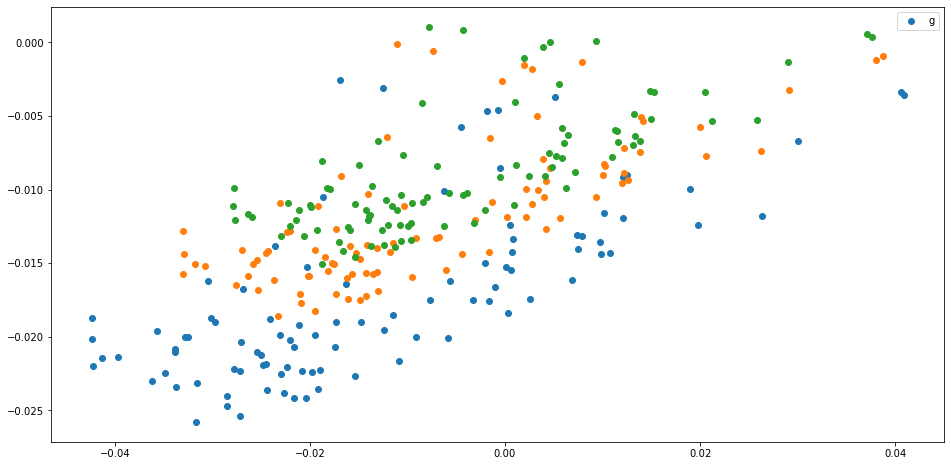

In [7]:
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

setup_seed(80)

path = netG(train0,train0.shape[0],50)
G2 = path[:,11,:]
G4 = path[:,19,:]
G7 = path[:,24,:]
G8 = path[:,35,:]
G9 = path[:,44,:]
G10 = path[:,49,:]
print(a(G2,train2),a(G4,train4),a(G7,train7))

T0 = train0.detach().cpu().numpy()
T2 = train2.detach().cpu().numpy()
T4 = train4.detach().cpu().numpy()
T7 = train7.detach().cpu().numpy()
G2 = G2.detach().cpu().numpy()
G4 = G4.detach().cpu().numpy()
G7 = G7.detach().cpu().numpy()
G8 = G8.detach().cpu().numpy()
G9 = G9.detach().cpu().numpy()
G10 = G10.detach().cpu().numpy()


plt.figure(figsize=(16,8))
plt.scatter(G2[:,0],G2[:,1],label="g")


plt.scatter(G4[:,0],G4[:,1])


plt.scatter(G7[:,0],G7[:,1])

plt.legend()

## RNA velocity

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


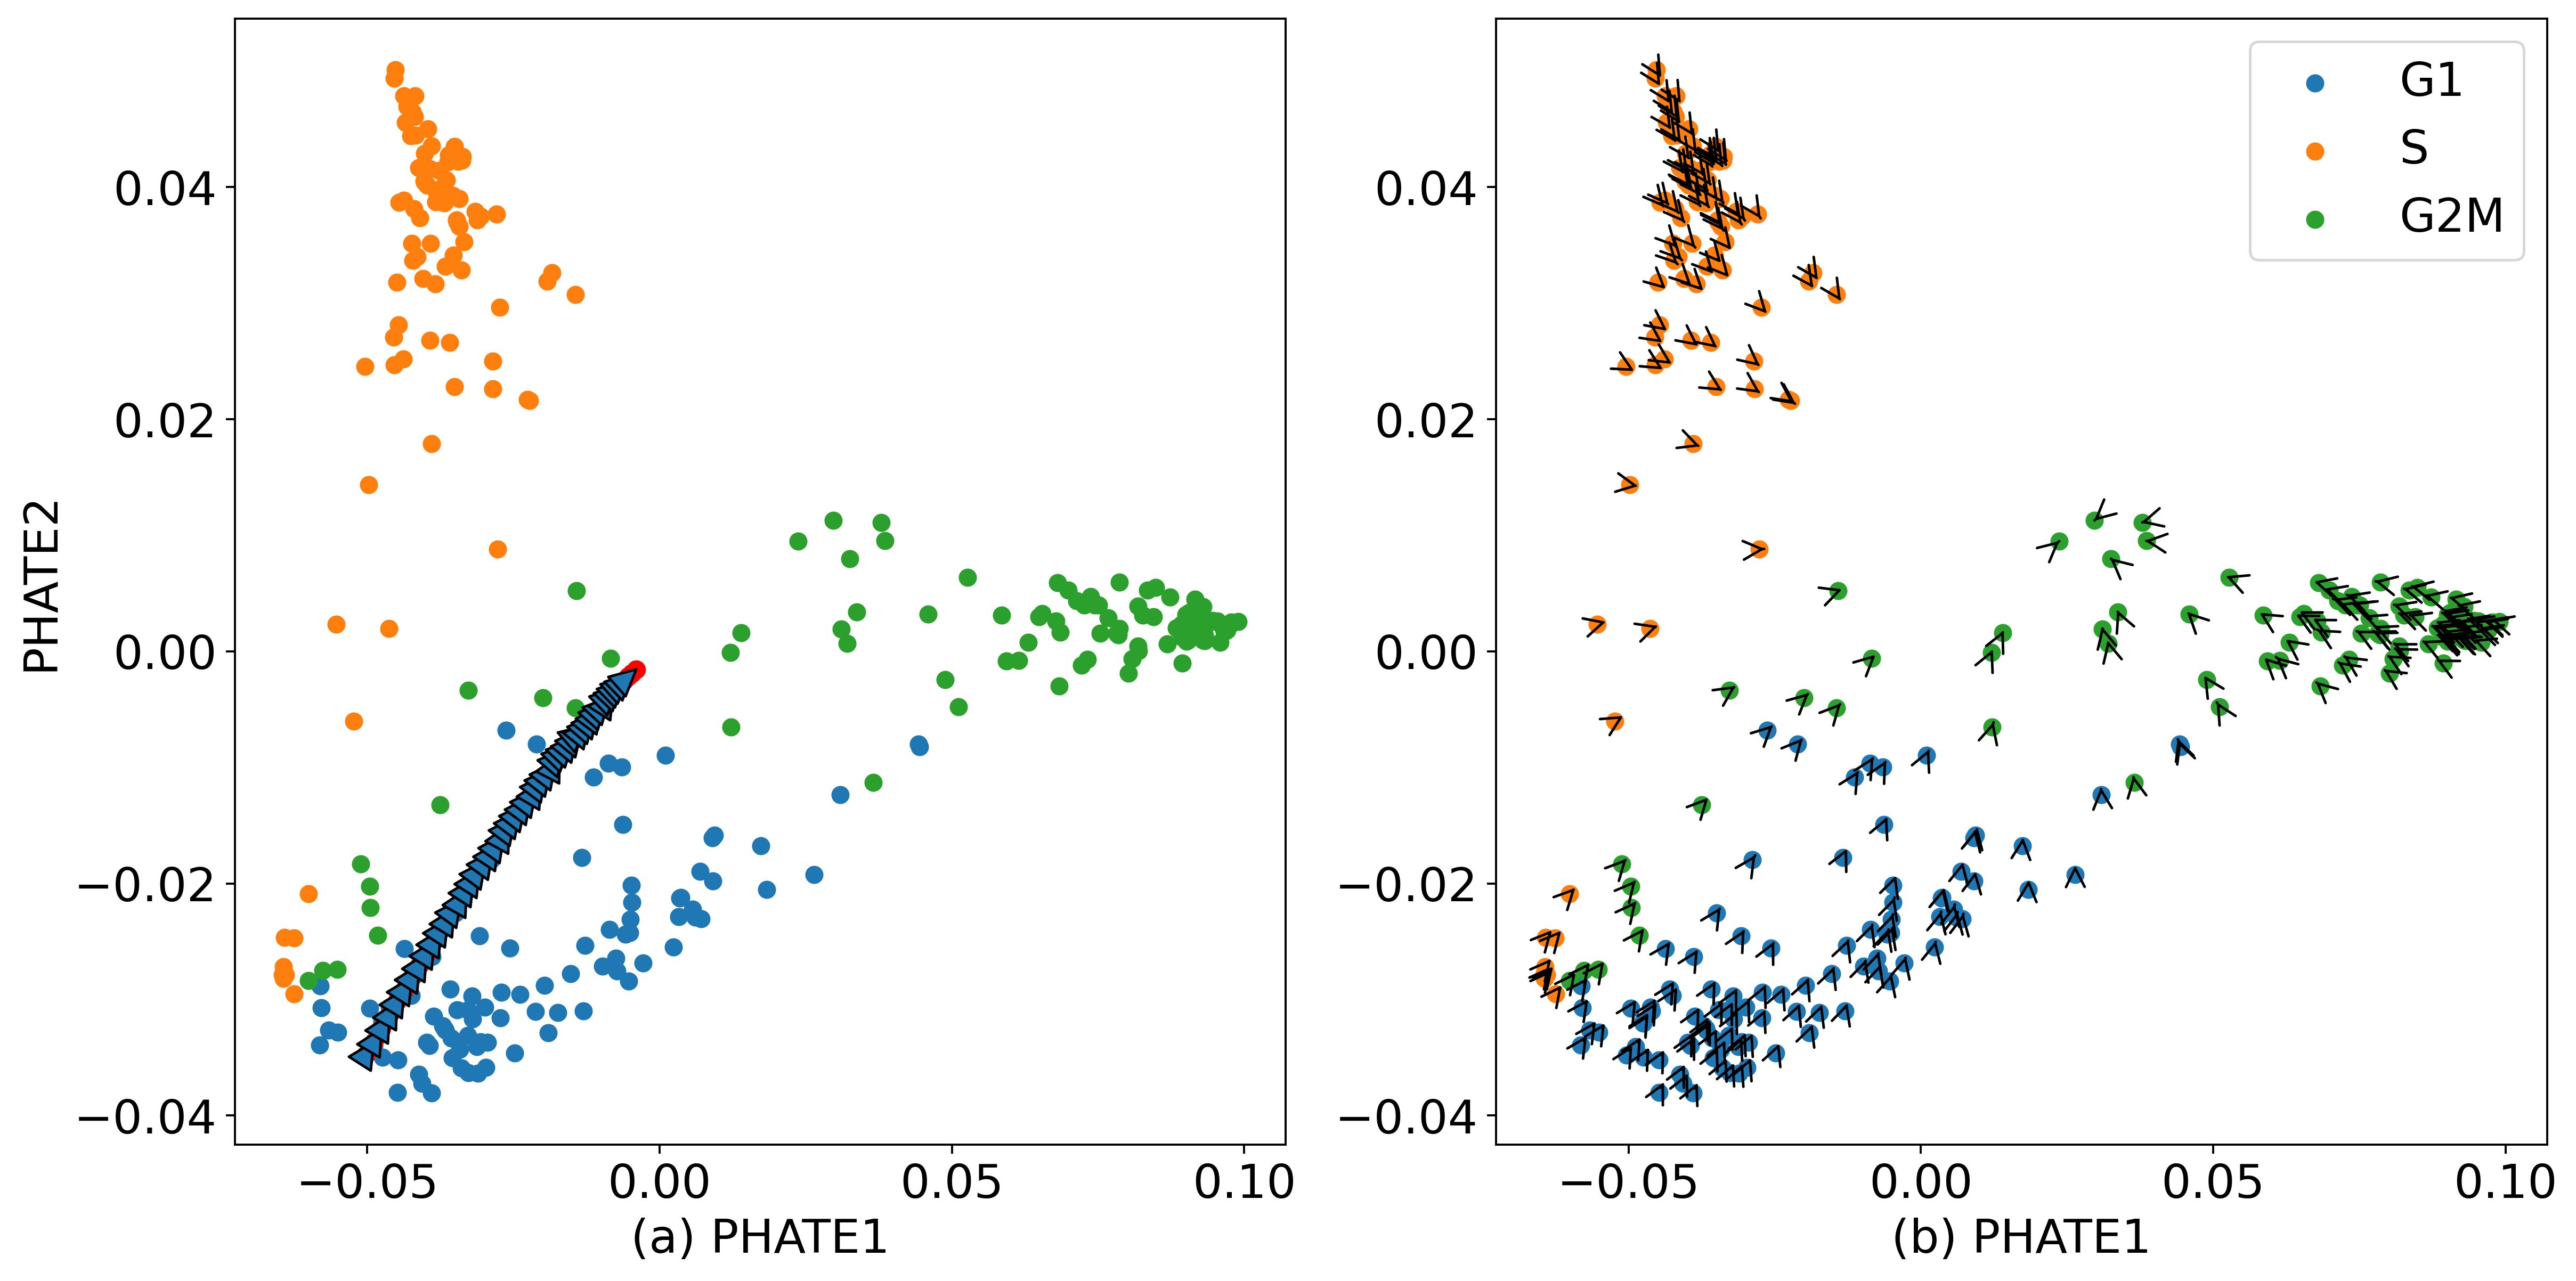

In [8]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

plt.figure(figsize=(16,8),dpi=350)

plt.subplot(1,2,1)
plt.scatter(T0[:,0],T0[:,1],label="G1")
plt.scatter(T2[:,0],T2[:,1],label='S')
plt.scatter(T4[:,0],T4[:,1],label="G2M")

plt.xlabel("(a) PHATE1")
plt.ylabel("PHATE2")

array = path[0].detach().cpu().numpy()
plt.scatter(array[:,0],array[:,1],c="red",s=40)
for j in range(array.shape[0]-1):
    plt.annotate(s="", xytext=(array[j,0], array[j,1]), xy=(array[j+1,0], array[j+1,1]),arrowprops=dict(width=2,headlength=10,headwidth=10))

plt.subplot(1,2,2)
plt.scatter(T0[:,0],T0[:,1],label="G1")
plt.scatter(T2[:,0],T2[:,1],label='S')
plt.scatter(T4[:,0],T4[:,1],label="G2M")

plt.xlabel("(b) PHATE1")

start = train0
end = start + netG.drift(start)*netG.step_size

for j in range(start.shape[0]):
        plt.annotate(s="", xytext=(start[j,0], start[j,1]), xy=(end[j,0], end[j,1]),arrowprops=dict(arrowstyle="->"),color='red')
        
start = train2
end = start + netG.drift(start)*netG.step_size

for j in range(start.shape[0]):
        plt.annotate(s="", xytext=(start[j,0], start[j,1]), xy=(end[j,0], end[j,1]),arrowprops=dict(arrowstyle="->"),color='red')
        
start = train4
end = start + netG.drift(start)*netG.step_size

for j in range(start.shape[0]):
        plt.annotate(s="", xytext=(start[j,0], start[j,1]), xy=(end[j,0], end[j,1]),arrowprops=dict(arrowstyle="->"),color='red')
        
plt.legend()

plt.savefig("./images/cycle_ou.eps",format="eps")